## Topic Modeling: LDA

 This notebook includes the process of training an LDA (Latent Dirichlet allocation) model.
 
#### Input:

ws2_1_article_clean.csv: 

This dataset contains all the clean articles, obtained from the `ws2_1_data_preparation` notebook.

#### Output:

covid_topic_<strong>XX</strong>.html:

The code will produce the LDA plot as html file where <strong>XX</strong> is the optimal number of topics obtained from analyzing the LDA results.

ws_2_article_topic_<strong>XX</strong>.csv:

The code will produce the LDA results as features and save them into this file where <strong>XX</strong> is the optimal number of topics. It is structured in 9 columns: an article ID, an article (original text), a number of words (in the article), a cleaned version of the text, the number of words (in the cleaned text), a publication date, a dominant topic in the article, the weight of the topic, a set of keywords related to the topic, and a topic label.
 

#### Topic modeling process includes:

- Include all the dependencies
- Import clean data
- Train the LDA model and compute the coherence metric
- Visualize the topics
- LDA as feature
- Map manual labels to topics


### Include all the dependencies

In [1]:
import pandas as pd
import numpy as np

!pip install gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

!pip install pyLDAvis
import pyLDAvis.gensim

pd.options.display.max_colwidth = 200
import warnings
warnings.filterwarnings('ignore')

     |################################| 24.2MB 7.6MB/s eta 0:00:01300:0303a 0:00:02  | 11.5MB 7.6MB/s eta 0:00:02ta 0:00:02#################     | 20.4MB 7.6MB/s eta 0:00:01  | 21.8MB 7.6MB/s eta 0:00:01
     |################################| 112kB 31.9MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.0.0-cp36-none-any.whl size=101342 sha256=a8e5de3012aa335bde9863828cba4d43719b006194cd77641e16a92e101a2c1b
  Stored in directory: /home/wsuser/.cache/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built smart-open
     |################################| 1.6MB 6.8MB/s eta 0:00:01
     |################################| 307kB 30.3MB/s eta 0:00:01#################   | 276kB 30.3MB/s eta 0:00:01
     |################################| 552kB 31.5MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=f18109d12ca1ec6bdb8ded32e82ec013a67bad49183c19863c195d073787c954
  Stored in directo

### Configuration parameters

In [4]:
# The path to the output folder where all the outputs will be saved
output_path = "/project_data/data_asset"

### Import Clean Data

In [3]:
# import the clean articles
articles = pd.read_csv(f"{output_path}/ws2_1_article_clean.csv")
articles.head()

,article_id,article,date,n_words,article_clean,n_words_clean
0,0,an acquaintance in Post-Polio >Syndrome This apparently is not recognised in New Zealand and different >symptons ( eg chest complaints) are treated separately. Does anone have >any information on ...,2020-01-01,160,acquaintance post polio syndrome apparently new zealand different symptons chest complaint separately anone information anyone else medical information subject specific question one likely textboo...,64
1,1,"homore in high school. Before that, I used to get bloody noses, nighttime asthma attacks, and eyes so itchy I couldn't get to sleep. After about 6 months on the shots, most of those symptoms were ...",2020-01-02,81,homore high school bloody nose nighttime asthma attack eye itchy get month shot symptom back shot due college allergy little bad still nowhere bad yes shot,26
2,2,"7:26 GMT On 5 Apr 93 23:27:26 GMT, (Vida Morkunas) said: Vida> Can one develop inner-ear problems from too much flying? I hear Vida> that pilots and steward/esses have a limit as to the maximum Vi...",2020-01-03,280,gmt apr gmt vida morkunas vida inner ear problem much hear vida pilot steward es maximum vida number hour limit vida main problem many long haul hour vida trip crew rest requirement undue fatigue ...,123
3,3,"tes about heat shock proteins (HSP's) and DNA. I hate to be derogatory, but in this case I think it's warranted. HSP's are part of the cellular response to stress. The only reason they are called ...",2020-01-04,159,te heat shock protein hsp dna hate derogatory case hsp part cellular response reason heat shock protein first heat shock dead tissue meat protein dead dna completely stomach way much eat healthy d...,55
4,4,"now mapping the human genome. We will > then start to work on manipulation of that genome. Using genetic > engineering, we will be able to insert whatever genes we want. > No breeding, no ""hybrids...",2020-01-05,290,human genome manipulation genome genetic engineering able gene breeding hybrid ethical question race disease free long arnold schwartzenegger superman even probably year possible disassemble assem...,119


### Train LDA Model

Here we train the LDA model and compute the coherence metric for a range of topic numbers. This metric calculates topic coherence for topic models which is the degree of semantic similarity between high scoring words in a topic. 

First, we create the term dictionary of our corpus, where every unique term is assigned an index. Then, we filter the least and most frequent words and convert the list of documents (corpus) into Document Term Matrix using the dictionary. We train LDA and obtain the number of topics where the topic coherence is the highest. Finally, we train the LDA model with the optimal number of topics.

In [5]:
words = [text.split() for text in articles['article_clean']]

In [6]:
# create the term dictionary of courpus
dictionary = corpora.Dictionary(words)

# filter the least and most frequent words: filters if less than no_below, more than no_above
dictionary.filter_extremes(no_below=10, no_above=0.9) 
dictionary.compactify()

# convert list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(word) for word in words]

In [7]:
# train LDA, computing the coherence score for a range of topics
coherence_scores = []

for num_topics in range(2, 14, 2):
    
    print(f"Number of topics: ", num_topics)
    
    # create the object for LDA model using gensim library
    Lda = gensim.models.ldamulticore.LdaMulticore

    # run and train LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, 
                   num_topics=num_topics, 
                   id2word = dictionary, 
                   passes=20, 
                   chunksize = 2000, 
                   random_state=42,
                   workers=6)
    
    # compute the coherence score
    coherence_model = CoherenceModel(model=ldamodel, 
                                     texts=words, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    
    coherence_scores.append((num_topics, coherence_lda))

coherence_scores = [*zip(*coherence_scores)]

Number of topics:  2
Number of topics:  4
Number of topics:  6
Number of topics:  8
Number of topics:  10
Number of topics:  12


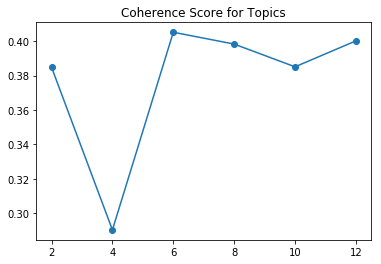

In [8]:
# plot the coherence score for topics
plt.plot(coherence_scores[0], coherence_scores[1], marker='o')
plt.title('Coherence Score for Topics')
plt.show()

In [9]:
# set the number of topics where coherence score is the highest
num_topics = 6

# run and train LDA model on the document term matrix.
Lda = gensim.models.ldamulticore.LdaMulticore

ldamodel = Lda(doc_term_matrix, 
               num_topics=num_topics, 
               id2word=dictionary, 
               passes=20, 
               chunksize=10000, 
               random_state=42,
               workers=6)

In [10]:
# view the topics with their most important words and their proportions
ldamodel.print_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.042*"science" + 0.026*"problem" + 0.024*"well" + 0.021*"pain" + 0.020*"much" + 0.020*"thing" + 0.018*"doctor" + 0.017*"still" + 0.016*"scientific" + 0.016*"time"'),
 (1,
  '0.031*"study" + 0.030*"food" + 0.027*"msg" + 0.023*"people" + 0.023*"blood" + 0.022*"human" + 0.019*"article" + 0.018*"brain" + 0.017*"anyone" + 0.017*"diet"'),
 (2,
  '0.059*"system" + 0.054*"field" + 0.045*"university" + 0.044*"program" + 0.030*"technique" + 0.030*"center" + 0.029*"information" + 0.028*"computer" + 0.027*"david" + 0.027*"problem"'),
 (3,
  '0.053*"food" + 0.045*"msg" + 0.042*"bank" + 0.034*"gordon" + 0.030*"time" + 0.028*"soon" + 0.027*"intellect" + 0.027*"skepticism" + 0.027*"chastity" + 0.025*"shameful"'),
 (4,
  '0.044*"available" + 0.036*"system" + 0.033*"program" + 0.032*"time" + 0.030*"information" + 0.027*"computer" + 0.022*"edu" + 0.022*"number" + 0.021*"type" + 0.021*"mail"'),
 (5,
  '0.074*"health" + 0.054*"disease" + 0.042*"medical" + 0.039*"patient" + 0.031*"year" + 0.026*"in

### Visualization

For understanding the LDA plot:
    
- click a circle in the left panel to select a topic.
- the bar chart in the right panel will display the 30 most relevant terms for the selected topic.
- the red bars represent the frequency of a term in a given topic, (proportional to p(term | topic)). 
- the blue bars represent a term's frequency across the entire corpus, (proportional to p(term)). 
- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic. 
- large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.

In [11]:
# visualize the intractive LDA plot
lda_display = pyLDAvis.gensim.prepare(ldamodel, 
                                      doc_term_matrix, 
                                      dictionary, 
                                      sort_topics=False)
pyLDAvis.display(lda_display)

In [12]:
# save the plot in html format
pyLDAvis.save_html(lda_display, f"{output_path}/covid_topic_{num_topics}.html")

### LDA as feature

Here we get the dominant topic and its proportion per document, and concatenate them with the main dataset.

In [13]:
# user inputs
corpus = doc_term_matrix
texts = articles
df = articles

In [14]:
# function to get dominant topic, percentage of contribution, and keywords for each document
def format_topics_sentences(ldamodel, corpus):

    results = []
    
    # get main topic in each document
    for row in ldamodel[corpus]:
        
        if len(row) == 0:
            continue
            
        row = list(sorted(row, key=lambda elem: elem[1], reverse=True))
        
        # get the dominant topic, percentage of contribution and keywords for each document
        topic_num, prop_topic = row[0]        
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        results.append((topic_num, round(prop_topic, 4), [topic_keywords]))
    
    df = pd.DataFrame.from_records(results, columns=['dominant_topic', 'weight', 'keywords'])
    
    return(df)

In [15]:
df_topics = format_topics_sentences(ldamodel, corpus)
df_topics.head()

,dominant_topic,weight,keywords
0,5,0.5039,"[health, disease, medical, patient, year, infection, state, use, service, number]"
1,0,0.4987,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]"
2,0,0.9729,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]"
3,0,0.5005,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]"
4,1,0.2706,"[study, food, msg, people, blood, human, article, brain, anyone, diet]"


In [16]:
# concatenate with the main dataset
articles = pd.concat([articles, df_topics.reindex(articles.index)], axis=1)

### Map to topic labels

Here we map the topic labels to the `dominant_topic` column obtained above. The topic labels are defined by analysing the LDA interactive plot.

In [18]:
# Define the topic labels for all the topics identified.
 
topics_dict = [[0, 'label_1'],
               [1, 'label_2'], 
               [2, 'label_3'], 
               [3, 'label_4'],
               [4, 'label_5'],
               [5, 'label_6']]

labels = pd.DataFrame(topics_dict, columns =['topic_num', 'topic_label'])

# merge with the main dataset
articles = pd.merge(articles, labels, how='left', left_on = 'dominant_topic', right_on='topic_num')
articles.drop("topic_num", axis=1, inplace=True)
articles.head()

,article_id,article,date,n_words,article_clean,n_words_clean,dominant_topic,weight,keywords,topic_label
0,0,an acquaintance in Post-Polio >Syndrome This apparently is not recognised in New Zealand and different >symptons ( eg chest complaints) are treated separately. Does anone have >any information on ...,2020-01-01,160,acquaintance post polio syndrome apparently new zealand different symptons chest complaint separately anone information anyone else medical information subject specific question one likely textboo...,64,5,0.5039,"[health, disease, medical, patient, year, infection, state, use, service, number]",label_6
1,1,"homore in high school. Before that, I used to get bloody noses, nighttime asthma attacks, and eyes so itchy I couldn't get to sleep. After about 6 months on the shots, most of those symptoms were ...",2020-01-02,81,homore high school bloody nose nighttime asthma attack eye itchy get month shot symptom back shot due college allergy little bad still nowhere bad yes shot,26,0,0.4987,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]",label_1
2,2,"7:26 GMT On 5 Apr 93 23:27:26 GMT, (Vida Morkunas) said: Vida> Can one develop inner-ear problems from too much flying? I hear Vida> that pilots and steward/esses have a limit as to the maximum Vi...",2020-01-03,280,gmt apr gmt vida morkunas vida inner ear problem much hear vida pilot steward es maximum vida number hour limit vida main problem many long haul hour vida trip crew rest requirement undue fatigue ...,123,0,0.9729,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]",label_1
3,3,"tes about heat shock proteins (HSP's) and DNA. I hate to be derogatory, but in this case I think it's warranted. HSP's are part of the cellular response to stress. The only reason they are called ...",2020-01-04,159,te heat shock protein hsp dna hate derogatory case hsp part cellular response reason heat shock protein first heat shock dead tissue meat protein dead dna completely stomach way much eat healthy d...,55,0,0.5005,"[science, problem, well, pain, much, thing, doctor, still, scientific, time]",label_1
4,4,"now mapping the human genome. We will > then start to work on manipulation of that genome. Using genetic > engineering, we will be able to insert whatever genes we want. > No breeding, no ""hybrids...",2020-01-05,290,human genome manipulation genome genetic engineering able gene breeding hybrid ethical question race disease free long arnold schwartzenegger superman even probably year possible disassemble assem...,119,1,0.2706,"[study, food, msg, people, blood, human, article, brain, anyone, diet]",label_2


In [19]:
# save data in data assets
articles.to_csv(f"{output_path}/ws_2_article_topic_{num_topics}.csv", index=False)

#### Authors
    
* **Mehrnoosh Vahdat** is Data Scientist with Data Science & AI Elite team where she specializes in Data Science, Analytics platforms, and Machine Learning solutions.
* **Vincent Nelis** is Senior Data Scientist with Data Science & AI Elite team where he specializes in Data Science, Analytics platforms, and Machine Learning solutions.
* **Anthony Ayanwale** is Data Scientist with CPAT team where he specializes in Data Science, Analytics platforms, and Machine Learning solutions.

Copyright © IBM Corp. 2020. Licensed under the Apache License, Version 2.0. Released as licensed Sample Materials.